In [3]:
import pandas as pd
import ee
import geemap
import folium
from IPython.display import Image
import imageio
import ipyleaflet 
import math
from matplotlib import pyplot as plt
import sys
import warnings
import cv2
warnings.filterwarnings('ignore')

In [4]:
# personal modules
sys.path.append('../src')
from fishnet import Fishnet

# update files automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
ee.Initialize(project="jpmorgancapstone")

# Extract images in bulk for the fishnet

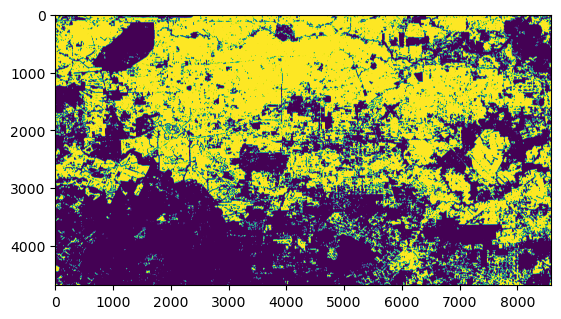

In [77]:
image = imageio.imread('../Images/built_image.png') # for Victor
# keep only the first band
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image)

In [78]:
# Create an instance of the Fishnet class
fishnet_creator = Fishnet('../Gis/Texas_State_Boundary/State.shp', 1, overlay_method='union', clip=False) # Victor

# Create the fishnet
fishnet_creator.create_fishnet()

# Define the larger bounding box
region = [-95.799944,29.374853,-95.028636,29.795492]

# Filter the fishnet by the larger bounding box
filtered_fishnet = fishnet_creator.filter_fishnet_by_bbox(region)

100%|██████████| 630/630 [00:04<00:00, 141.89it/s]


Generating polygons...
Success. Fishnet created.


In [89]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box

def latlong_to_pixel(bbox, region, img_shape):
    """
    Convert lat/long coordinates to pixel coordinates.

    Parameters:
    bbox (tuple): A tuple of (xmin, ymin, xmax, ymax) representing the bounding box.
    region (list): A list of [x1, x2, x3, x4] representing the lat/long coordinates of the 4 image corners.
    img_shape (tuple): A tuple of (height, width) representing the image shape.

    Returns:
    tuple: A tuple of (xmin, ymin, xmax, ymax) representing the pixel coordinates of the bounding box.
    """
    img_height, img_width = img_shape
    x1, x2, x3, x4 = region

    min_lon, max_lon = min(x1, x3), max(x1, x3)
    min_lat, max_lat = min(x2, x4), max(x2, x4)
    xmin, ymin, xmax, ymax = bbox

    # Normalize the bounding box coordinates
    x_min_pixel = int((xmin - min_lon) / (max_lon - min_lon) * img_width)
    x_max_pixel = int((xmax - min_lon) / (max_lon - min_lon) * img_width)
    y_min_pixel = int((1 - (ymax - min_lat) / (max_lat - min_lat)) * img_height)
    y_max_pixel = int((1 - (ymin - min_lat) / (max_lat - min_lat)) * img_height)

    return x_min_pixel, y_min_pixel, x_max_pixel, y_max_pixel

def get_pixel_coordinates(geodataframe):
    """
    Convert lat/long coordinates to pixel coordinates.

    Parameters:
    geodataframe (geopandas.geodataframe.GeoDataFrame): A geodataframe containing the bounding boxes.

    Returns:
    pandas.Series: A pandas series containing the pixel coordinates of the bounding boxes.
    """
    pixel_coordinates = geodataframe['geometry'].apply(lambda x: latlong_to_pixel(x.bounds, region, (img_height, img_width)))
    return pixel_coordinates

from PIL import Image
import geopandas as gpd
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm

def mean_pixel_values(img_arr, bounding_boxes_gdf):
    """
    Compute the mean pixel value within each bounding box in a geodataframe, for a given image.

    Parameters:
    -----------
    img_arr: numpy.ndarray
        NumPy array of the image.
    bounding_boxes_gdf: geopandas.GeoDataFrame
        Geodataframe of bounding boxes with IDs.

    Returns:
    --------
    list:
        A list of mean pixel values for each bounding box in the geodataframe.
    """
    print("Converting image to PIL object...")
    # Convert the NumPy array to a PIL Image object
    img = Image.fromarray(cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB))

    print("Converting bounding box coordinates to pixel coordinates...")
    # Convert the bounding box coordinates to pixel coordinates
    bounding_boxes_gdf["PixelCoordinates"] = bounding_boxes_gdf["ImageCoordinates"].apply(lambda x: (int(x[0]), int(x[1]), int(x[2]), int(x[3])))

    print("Extracting pixels from each bounding box and computing mean pixel value...")
    # Compute the mean pixel value within each bounding box
    mean_pixel_values = []
    with tqdm(total=len(bounding_boxes_gdf)) as pbar:
        for idx, row in bounding_boxes_gdf.iterrows():
            pixel_box = img.crop(row["PixelCoordinates"])
            mean_pixel_value = np.mean(pixel_box) #int(pd.DataFrame(np.array(pixel_box.getdata()).reshape((-1, 3))).mean().mean())
            mean_pixel_values.append(mean_pixel_value)
            pbar.update(1)

    return mean_pixel_values


In [82]:
filtered_fishnet["ImageCoordinates"] = get_pixel_coordinates(filtered_fishnet)
filtered_fishnet["MeanPixels"] = mean_pixel_values(image, filtered_fishnet)

Converting image to PIL object...
Converting bounding box coordinates to pixel coordinates...
Extracting pixels from each bounding box and computing mean pixel value...


100%|██████████| 1222/1222 [00:11<00:00, 105.19it/s]


In [90]:
filtered_fishnet["MeanPixels"] = mean_pixel_values(image, filtered_fishnet)

Converting image to PIL object...
Converting bounding box coordinates to pixel coordinates...
Extracting pixels from each bounding box and computing mean pixel value...


100%|██████████| 1222/1222 [00:00<00:00, 9031.12it/s]


<Axes: >

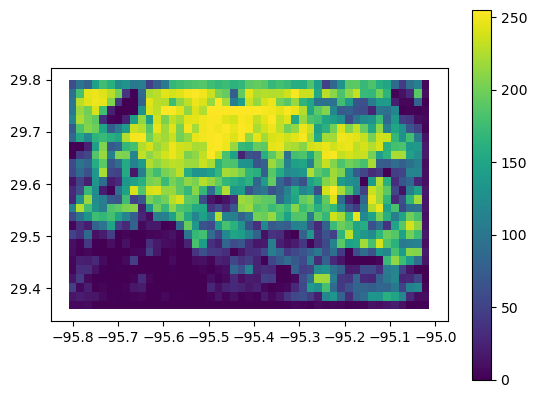

In [91]:
# plot the MeanPixels on the fishnet and map
filtered_fishnet.plot(column='MeanPixels', cmap='viridis', legend=True)

In [92]:
filtered_fishnet

,id,geometry,ImageCoordinates,PixelCoordinates,MeanPixels
162048,162048,"POLYGON ((-95.80892 29.35935, -95.79199 29.359...","(-99, 4667, 88, 4855)","(-99, 4667, 88, 4855)",5.331238
162049,162049,"POLYGON ((-95.79199 29.35935, -95.77505 29.359...","(88, 4667, 277, 4855)","(88, 4667, 277, 4855)",5.741304
162050,162050,"POLYGON ((-95.77505 29.35935, -95.75812 29.359...","(277, 4667, 465, 4855)","(277, 4667, 465, 4855)",7.452892
162051,162051,"POLYGON ((-95.75812 29.35935, -95.74119 29.359...","(465, 4667, 654, 4855)","(465, 4667, 654, 4855)",0.000000
162052,162052,"POLYGON ((-95.74119 29.35935, -95.72425 29.359...","(654, 4667, 842, 4855)","(654, 4667, 842, 4855)",0.656547
...,...,...,...,...,...
181490,181490,"POLYGON ((-95.09772 29.78268, -95.08079 29.782...","(7818, -45, 8007, 142)","(7818, -45, 8007, 142)",87.222222
181491,181491,"POLYGON ((-95.08079 29.78268, -95.06385 29.782...","(8007, -45, 8195, 142)","(8007, -45, 8195, 142)",44.020793
181492,181492,"POLYGON ((-95.06385 29.78268, -95.04692 29.782...","(8195, -45, 8384, 142)","(8195, -45, 8384, 142)",92.575758
181493,181493,"POLYGON ((-95.04692 29.78268, -95.02999 29.782...","(8384, -45, 8572, 142)","(8384, -45, 8572, 142)",110.120890


In [65]:
filtered_fishnet.head(100)

,id,geometry,ImageCoordinates,PixelCoordinates,MeanPixels
162048,162048,"POLYGON ((-95.80892 29.35935, -95.79199 29.359...","(-99, 4667, 88, 4855)","(-99, 4667, 88, 4855)",5
162049,162049,"POLYGON ((-95.79199 29.35935, -95.77505 29.359...","(88, 4667, 277, 4855)","(88, 4667, 277, 4855)",5
162050,162050,"POLYGON ((-95.77505 29.35935, -95.75812 29.359...","(277, 4667, 465, 4855)","(277, 4667, 465, 4855)",5
162051,162051,"POLYGON ((-95.75812 29.35935, -95.74119 29.359...","(465, 4667, 654, 4855)","(465, 4667, 654, 4855)",5
162052,162052,"POLYGON ((-95.74119 29.35935, -95.72425 29.359...","(654, 4667, 842, 4855)","(654, 4667, 842, 4855)",5
...,...,...,...,...,...
163601,163601,"POLYGON ((-95.79199 29.39322, -95.77505 29.393...","(88, 4290, 277, 4478)","(88, 4290, 277, 4478)",5
163602,163602,"POLYGON ((-95.77505 29.39322, -95.75812 29.393...","(277, 4290, 465, 4478)","(277, 4290, 465, 4478)",5
163603,163603,"POLYGON ((-95.75812 29.39322, -95.74119 29.393...","(465, 4290, 654, 4478)","(465, 4290, 654, 4478)",5
163604,163604,"POLYGON ((-95.74119 29.39322, -95.72425 29.393...","(654, 4290, 842, 4478)","(654, 4290, 842, 4478)",5


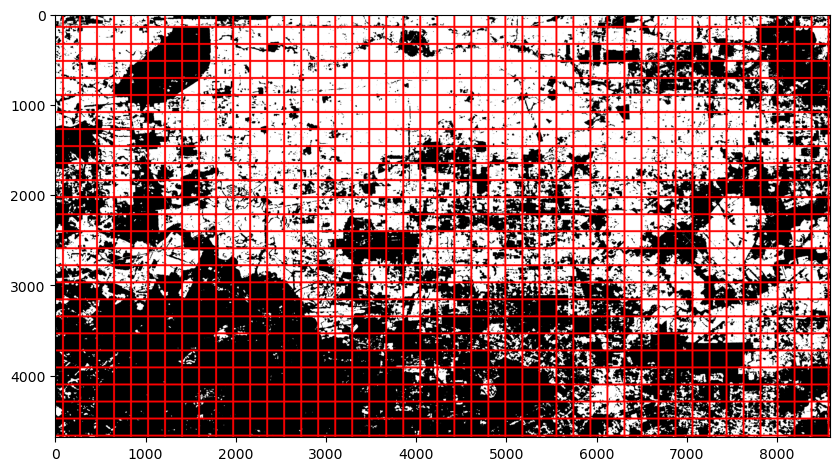

In [61]:

# Load your image
image = cv2.imread('../Images/built_image.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
img_height, img_width, _ = image.shape

# Define the lat/long coordinates of the 4 image corners
region = [-95.799944,29.374853,-95.028636,29.795492]

# Iterate through the bounding boxes in the filtered fishnet
for _, row in filtered_fishnet.iterrows():
    bbox = row['geometry'].bounds
    pixel_bbox = latlong_to_pixel(bbox, region, (img_height, img_width))
    cv2.rectangle(image, (pixel_bbox[0], pixel_bbox[1]), (pixel_bbox[2], pixel_bbox[3]), (255, 0, 0), 20)

# Plot the image with the bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

In [23]:
for bb in filtered_fishnet['geometry']:
    print(bb)


POLYGON ((-95.80891919665841 29.359350263811088, -95.79198589885162 29.359350263811088, -95.79198589885162 29.37628356161787, -95.80891919665841 29.37628356161787, -95.80891919665841 29.359350263811088))
POLYGON ((-95.79198589885162 29.359350263811088, -95.77505260104483 29.359350263811088, -95.77505260104483 29.37628356161787, -95.79198589885162 29.37628356161787, -95.79198589885162 29.359350263811088))
POLYGON ((-95.77505260104483 29.359350263811088, -95.75811930323805 29.359350263811088, -95.75811930323805 29.37628356161787, -95.77505260104483 29.37628356161787, -95.77505260104483 29.359350263811088))
POLYGON ((-95.75811930323805 29.359350263811088, -95.74118600543127 29.359350263811088, -95.74118600543127 29.37628356161787, -95.75811930323805 29.37628356161787, -95.75811930323805 29.359350263811088))
POLYGON ((-95.74118600543127 29.359350263811088, -95.72425270762449 29.359350263811088, -95.72425270762449 29.37628356161787, -95.74118600543127 29.37628356161787, -95.74118600543127 2

In [8]:
fishnet_creator = Fishnet('../Gis/Texas_State_Boundary/State.shp', 0.25, overlay_method='union', clip=False) # Victor
fishnet = fishnet_creator.create_fishnet()
fishnet.head()

100%|██████████| 2519/2519 [01:08<00:00, 36.77it/s]


Generating polygons...
Cliping fishinet to boundaries...


In [ ]:
# SAVE FISHNET